In [1]:
import os
from utils import PER

import vizdoom

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras

In [191]:
def load_random_data(test=False, batch_size=32):
    
    random_video = np.random.randint(10)
    path = os.path.join("vizdoom_dataset")
    if test == True:
        random_video = np.random.randint(5)
        path = os.path.join("test")
    
    '''states = np.load(path+"\\states{}.npy".format(random_video), allow_pickle=True)
    actions = np.load(path+"\\actions{}.npy".format(random_video), allow_pickle=True)
    rewards = np.load(path+"\\rewards{}.npy".format(random_video), allow_pickle=True)
    n_states = np.load(path+"\\n_states{}.npy".format(random_video), allow_pickle=True)
    dones = np.load(path+"\\dones{}.npy".format(random_video), allow_pickle=True)'''
    states = np.load(path+"\\states{}.npy".format(0), allow_pickle=True)
    actions = np.load(path+"\\actions{}.npy".format(0), allow_pickle=True)
    rewards = np.load(path+"\\rewards{}.npy".format(0), allow_pickle=True)
    n_states = np.load(path+"\\n_states{}.npy".format(0), allow_pickle=True)
    dones = np.load(path+"\\dones{}.npy".format(0), allow_pickle=True)
    
    print(states.shape)
    
    video_len = dones.shape[0]
    random_video_indexes = np.random.randint(video_len-2, size=batch_size)
    #random_video_indexes = [x for x in range(32)]
    
    return states, actions, rewards, n_states, dones, random_video_indexes

In [581]:
path = os.path.join("vizdoom_dataset")
file = np.load(path+"\\states0.npy", allow_pickle=True)
print(file.shape)

t_file = file*255
t_file = t_file.astype(np.uint8)

test_img = Image.fromarray(t_file[10][0][:-35], "RGB")

plt.imshow(test_img)
plt.show()

plt.imshow(np.array(test_img))
plt.show()

test_max_pool = keras.layers.MaxPooling2D(2)(np.array(test_img).reshape(1, 64, 64, 3))
#again = keras.layers.MaxPooling2D(2)(again)

print(test_max_pool.shape)
plt.imshow(test_max_pool.numpy().reshape(32, 32, 3))
plt.show()

test_conv2d = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="same",
                       kernel_regularizer=keras.regularizers.l2(0.01), activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="same",
                       kernel_regularizer=keras.regularizers.l2(0.01), activation="relu"),
    keras.layers.Dropout(0.5),
    #keras.layers.Conv2D(20, kernel_size=2, strides=1, padding="same", 
                       #kernel_regularizer=keras.regularizers.l2(0.02), activation="relu"),
    #keras.layers.Conv2D(32, kernel_size=3, strides=1, padding="same",
                       #kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Conv2D(3, kernel_size=2, strides=1, padding="same")
])(np.array(test_img).reshape(1, 64, 64, 3).astype(np.float32))

print(test_conv2d.shape)

plt.imshow(test_conv2d.numpy()[0].astype(np.uint8))
plt.show()

(364, 64, 64, 4)


ValueError: not enough image data

In [192]:
input_shape = (64, 64, 4)
n_outputs = 7
loss_fn = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(lr=1e-3)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=8, strides=4, padding="valid", input_shape=input_shape,
                       activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="valid",
                       activation="relu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=4, strides=1, padding="valid",
                       activation="relu", kernel_initializer="he_normal"),
    
    #keras.layers.Flatten(),
    keras.layers.Reshape((1, -1)),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(n_outputs, activation="sigmoid")
])

'''model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=8, strides=4, padding="same", input_shape=input_shape),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(n_outputs)
])'''

model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.01))

target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

per = PER(5000)

In [193]:
def find_n_step_return(states, rewards, dones, random_video_index):
    frames_left = dones.shape[0] - random_video_index
    gamma = 0.95
    n_step_return = 0

    if frames_left < 10:
        n = frames_left
    else:
        n = 10
    
    if dones[random_video_index + n - 1] != 1:
        n_step_state = states[random_video_index + n - 1]
    else:
        n_step_state = states[-1]
        
    n_step_state = np.array(Image.fromarray(n_step_state, "RGB").resize((64, 64)).convert("L"))

    for i in range(n):
        n_step_return += (gamma**i) * (rewards[random_video_index + i])

    n_step_return += (gamma ** n) * np.max(model(n_step_state[np.newaxis]))

    print("N step return: ", n_step_return)
    return n_step_return

In [194]:
def training_step(target_model, model, loss_fn=loss_fn, optimizer=optimizer, prefill=False, rl=True):
    discount_factor = 0.95
    
    states, actions, rewards, n_states, dones, rand_idx = load_random_data()
    
    if rl is not False:
        n_step_rewards = find_n_step_return(states, rewards, dones, rand_idx)
        per.store([image_processor(states[rand_idx]), 
                   actions[rand_idx], n_step_rewards, 
                   image_processor(n_states[rand_idx]), dones[rand_idx]])

        BATCH_SIZE = 32
        tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
        xp = experiences

        states, actions, n_step_rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
        
        print(states.shape)
        states = states.reshape(BATCH_SIZE, 64, 64, 4)
        n_states = n_states.reshape(BATCH_SIZE, 64, 64, 4)
    
    if prefill == False:
        batched_states = np.array([states[x] for x in rand_idx])
        print(batched_states.shape)
        batched_actions = np.array([actions[x] for x in rand_idx])
        model.train_on_batch(batched_states, batched_actions)
        supervised_preds = model(batched_states)
        supervised_loss = keras.losses.BinaryCrossentropy(from_logits=True)(batched_actions, supervised_preds)
        print("Supervised loss: ", supervised_loss.numpy())
        
        if rl is not False:
            next_Q_values = target_model.predict(n_states)
            max_next_Q_values = np.max(next_Q_values, axis=1)
            target_Q_values = (n_step_rewards + 
                              (1 - dones) * discount_factor * max_next_Q_values)
            mask = actions

            print(states[-1].shape)


            with tf.GradientTape() as tape:
                all_Q_values = model(states)

                Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
                
                loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
                print("Total loss: ", loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            abs_error = tf.abs(target_Q_values - Q_values)
            per.batch_update(tree_idx, abs_error)

            return loss

In [195]:
def supervised_training(target_model, model, epochs=500):
    for epoch in range(epochs):
        print("Epoch: ", epoch+1)
        training_step(target_model, model, rl=False)
        
supervised_training(target_model, model)

Epoch:  1
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7493051
Epoch:  2
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7089505
Epoch:  3
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70462227
Epoch:  4
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7357782
Epoch:  5
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7412726
Epoch:  6
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7350053
Epoch:  7
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7327126
Epoch:  8
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71889716
Epoch:  9
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71201825
Epoch:  10
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7189586
Epoch:  11
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7149825
Epoch:  12
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7097724
Epoch:  13
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7160662
Epoch:  14
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.716824

Supervised loss:  0.71919173
Epoch:  115
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71405286
Epoch:  116
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70973843
Epoch:  117
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7094506
Epoch:  118
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7145057
Epoch:  119
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7122822
Epoch:  120
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71154875
Epoch:  121
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7133416
Epoch:  122
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71725273
Epoch:  123
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.72245884
Epoch:  124
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.72653496
Epoch:  125
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7222098
Epoch:  126
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7163916
Epoch:  127
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7179233
Epoch:  128
(412

(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7123395
Epoch:  228
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7121103
Epoch:  229
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.711885
Epoch:  230
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71767426
Epoch:  231
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70557034
Epoch:  232
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70889175
Epoch:  233
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7030481
Epoch:  234
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6995915
Epoch:  235
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70510936
Epoch:  236
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7069726
Epoch:  237
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.69805634
Epoch:  238
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7016877
Epoch:  239
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6948758
Epoch:  240
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised los

Supervised loss:  0.68478036
Epoch:  340
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.700081
Epoch:  341
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.68843806
Epoch:  342
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6978425
Epoch:  343
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7108425
Epoch:  344
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7029655
Epoch:  345
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70641637
Epoch:  346
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7006448
Epoch:  347
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7028558
Epoch:  348
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70276845
Epoch:  349
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7065596
Epoch:  350
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6864923
Epoch:  351
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6964063
Epoch:  352
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.6894611
Epoch:  353
(412, 64

(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7169698
Epoch:  452
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71537113
Epoch:  453
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7167604
Epoch:  454
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70938814
Epoch:  455
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71979
Epoch:  456
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7249916
Epoch:  457
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.731041
Epoch:  458
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.72747594
Epoch:  459
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71815044
Epoch:  460
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7284285
Epoch:  461
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.71744144
Epoch:  462
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.70708394
Epoch:  463
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.7042393
Epoch:  464
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss

In [ ]:
def prefill_per(target_model, model, times=100):
    for time in range(times):
        print("Prefilled: ", time + 1)
        training_step(target_model, model, prefill=True)

#prefill_per(target_model, model)

In [ ]:
def train_model(target_model, model, tau=50, n_epochs=50):
    all_loss = []
    for epoch in tf.range(n_epochs):
        print("Epoch: ", epoch + 1)
        loss = training_step(target_model, model, prefill=False)
        all_loss.append(float(loss))
        if epoch % tau == 0:
            target_model.set_weights(model.get_weights())
            
    plt.plot(all_loss)
    plt.show()
        
train_model(target_model, model)

(412, 64, 64, 4)
[[[0.15294118 0.21176471 0.20392157 0.1882353 ]
  [0.2        0.19607843 0.21568628 0.20392157]
  [0.2        0.18431373 0.13333334 0.2       ]
  ...
  [0.18039216 0.21176471 0.20784314 0.12156863]
  [0.16862746 0.20784314 0.15294118 0.19215687]
  [0.16078432 0.2        0.11764706 0.28235295]]

 [[0.15294118 0.21568628 0.20392157 0.1882353 ]
  [0.20392157 0.20392157 0.21568628 0.21176471]
  [0.21176471 0.18431373 0.12156863 0.21568628]
  ...
  [0.18431373 0.20392157 0.17254902 0.21176471]
  [0.2        0.21960784 0.14117648 0.24313726]
  [0.17254902 0.18039216 0.13725491 0.25490198]]

 [[0.15294118 0.2        0.1882353  0.2       ]
  [0.18431373 0.2        0.21568628 0.21176471]
  [0.19607843 0.18431373 0.12156863 0.21568628]
  ...
  [0.22745098 0.16470589 0.15294118 0.28627452]
  [0.19607843 0.18431373 0.14117648 0.22745098]
  [0.18039216 0.16470589 0.11372549 0.21176471]]

 ...

 [[0.18431373 0.13333334 0.19215687 0.20392157]
  [0.16078432 0.16078432 0.18431373 0.247

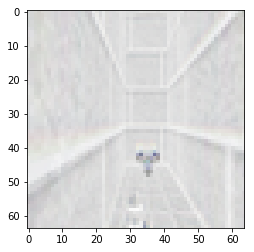

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.16862746 0.16862746 0.13725491 0.10196079]
  [0.16862746 0.18039216 0.09019608 0.09019608]
  [0.16470589 0.10196079 0.11764706 0.16470589]
  ...
  [0.15294118 0.1764706  0.11372549 0.15686275]
  [0.15686275 0.16078432 0.16078432 0.13725491]
  [0.14901961 0.16470589 0.18039216 0.10196079]]

 [[0.18039216 0.13725491 0.08235294 0.2627451 ]
  [0.16078432 0.17254902 0.07058824 0.12941177]
  [0.16470589 0.09803922 0.11764706 0.11372549]
  ...
  [0.1764706  0.1882353  0.11764706 0.16862746]
  [0.18431373 0.18039216 0.14901961 0.13333334]
  [0.16470589 0.15294118 0.13725491 0.08235294]]

 [[0.16078432 0.08235294 0.19607843 0.23921569]
  [0.16862746 0.13725491 0.10196079 0.23921569]
  [0.18431373 0.09803922 0.08627451 0.14509805]
  ...
  [0.17254902 0.15686275 0.10588235 0.17254902]
  [0.16078432 0.16470589 0.16862746 0.14901961]
  [0.16862746 0.14117648 0.14509805 0.08627451]]

 ...

 [[0.19215687 0

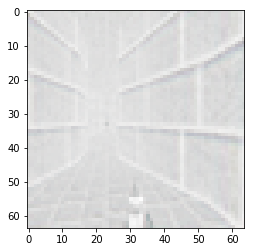

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.09411765 0.09411765 0.09411765 0.09411765]
  [0.10588235 0.10980392 0.10980392 0.10980392]
  [0.15294118 0.15294118 0.15294118 0.15294118]
  ...
  [0.18039216 0.18039216 0.18039216 0.18039216]
  [0.1764706  0.18039216 0.18039216 0.18039216]
  [0.1764706  0.18039216 0.18431373 0.18431373]]

 [[0.09803922 0.10196079 0.10196079 0.10196079]
  [0.10196079 0.10588235 0.10588235 0.10588235]
  [0.14117648 0.14117648 0.14117648 0.14117648]
  ...
  [0.1882353  0.1882353  0.1882353  0.1882353 ]
  [0.19215687 0.19215687 0.19607843 0.19607843]
  [0.15686275 0.16078432 0.16078432 0.16078432]]

 [[0.09019608 0.09019608 0.09019608 0.09019608]
  [0.11764706 0.12156863 0.12156863 0.12156863]
  [0.14509805 0.14509805 0.14509805 0.14509805]
  ...
  [0.19607843 0.19215687 0.19215687 0.19215687]
  [0.18039216 0.18039216 0.1882353  0.1882353 ]
  [0.14901961 0.14901961 0.14901961 0.14901961]]

 ...

 [[0.14901961 0

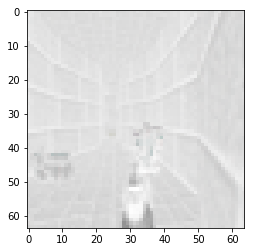

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 1 0]
(412, 64, 64, 4)
[[[0.21568628 0.13333334 0.13333334 0.12941177]
  [0.1882353  0.16078432 0.13725491 0.13333334]
  [0.18039216 0.16862746 0.14509805 0.15294118]
  ...
  [0.15294118 0.19215687 0.21176471 0.11764706]
  [0.15294118 0.18431373 0.19607843 0.13725491]
  [0.16470589 0.18431373 0.18431373 0.14509805]]

 [[0.19215687 0.13333334 0.14509805 0.12941177]
  [0.16862746 0.16470589 0.14117648 0.14509805]
  [0.18039216 0.16862746 0.14117648 0.13725491]
  ...
  [0.15686275 0.19607843 0.2        0.11764706]
  [0.1764706  0.18431373 0.18431373 0.13725491]
  [0.16862746 0.15294118 0.18431373 0.14117648]]

 [[0.16470589 0.13725491 0.13725491 0.12156863]
  [0.18039216 0.16862746 0.12941177 0.13333334]
  [0.1764706  0.14509805 0.12941177 0.13725491]
  ...
  [0.18039216 0.19607843 0.19607843 0.11764706]
  [0.18431373 0.19215687 0.18431373 0.13725491]
  [0.16862746 0.14117648 0.18431373 0.14117648]]

 ...

 [[0.18039216 0

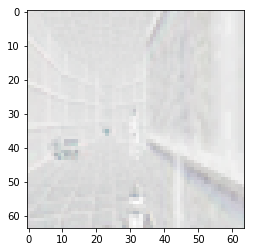

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 1 1 0 0 0]
(412, 64, 64, 4)
[[[0.16862746 0.16470589 0.13333334 0.09019608]
  [0.18039216 0.18431373 0.16862746 0.12156863]
  [0.16078432 0.16862746 0.18039216 0.16078432]
  ...
  [0.16078432 0.1764706  0.16078432 0.13333334]
  [0.16862746 0.17254902 0.16862746 0.14509805]
  [0.16078432 0.18431373 0.2        0.15686275]]

 [[0.16862746 0.15294118 0.08627451 0.1764706 ]
  [0.16470589 0.1764706  0.1254902  0.09019608]
  [0.16078432 0.17254902 0.17254902 0.11764706]
  ...
  [0.16078432 0.16862746 0.16862746 0.15294118]
  [0.1764706  0.2        0.15686275 0.14901961]
  [0.19607843 0.20392157 0.18431373 0.15294118]]

 [[0.18039216 0.10980392 0.1254902  0.2627451 ]
  [0.16862746 0.13333334 0.09803922 0.21176471]
  [0.16470589 0.16862746 0.10980392 0.11372549]
  ...
  [0.16862746 0.18431373 0.1882353  0.13725491]
  [0.18039216 0.19607843 0.15294118 0.14509805]
  [0.19215687 0.20392157 0.18039216 0.15294118]]

 ...

 [[0.20392157 0

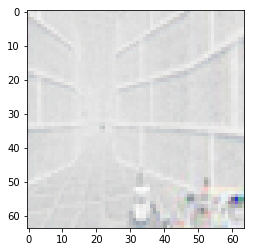

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.06666667 0.06666667 0.06666667 0.09019608]
  [0.07843138 0.07843138 0.07843138 0.07843138]
  [0.10588235 0.10588235 0.11372549 0.09019608]
  ...
  [0.1882353  0.1882353  0.1882353  0.2       ]
  [0.16470589 0.16470589 0.1882353  0.18431373]
  [0.16470589 0.16470589 0.15686275 0.1764706 ]]

 [[0.07058824 0.07058824 0.09019608 0.12156863]
  [0.07843138 0.07843138 0.09019608 0.09803922]
  [0.09019608 0.09019608 0.07843138 0.09019608]
  ...
  [0.19215687 0.19215687 0.1882353  0.19607843]
  [0.16078432 0.16078432 0.18431373 0.19607843]
  [0.16470589 0.16470589 0.15294118 0.16470589]]

 [[0.11764706 0.11764706 0.13725491 0.17254902]
  [0.10196079 0.10196079 0.10980392 0.14509805]
  [0.08627451 0.08627451 0.09019608 0.11764706]
  ...
  [0.18431373 0.18431373 0.18431373 0.16862746]
  [0.15686275 0.15686275 0.15686275 0.19607843]
  [0.16470589 0.16470589 0.15294118 0.17254902]]

 ...

 [[0.15686275 0

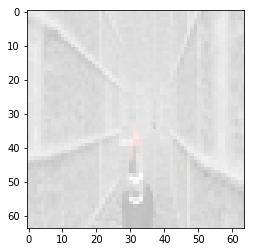

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.09019608 0.16470589 0.19607843 0.22352941]
  [0.1254902  0.08627451 0.24313726 0.19215687]
  [0.14117648 0.09019608 0.13725491 0.12156863]
  ...
  [0.15294118 0.2        0.07843138 0.09019608]
  [0.2        0.1882353  0.16078432 0.12156863]
  [0.2        0.17254902 0.2        0.14117648]]

 [[0.07843138 0.21568628 0.1764706  0.17254902]
  [0.08235294 0.19215687 0.19215687 0.2       ]
  [0.12941177 0.07843138 0.21176471 0.22352941]
  ...
  [0.16078432 0.16862746 0.11764706 0.12941177]
  [0.18431373 0.16862746 0.15686275 0.14901961]
  [0.1882353  0.16470589 0.18431373 0.12941177]]

 [[0.19607843 0.19607843 0.17254902 0.14117648]
  [0.09019608 0.22352941 0.17254902 0.18039216]
  [0.08627451 0.16862746 0.18039216 0.21176471]
  ...
  [0.18431373 0.14901961 0.14901961 0.20392157]
  [0.18431373 0.17254902 0.13725491 0.13333334]
  [0.18039216 0.16862746 0.15686275 0.12941177]]

 ...

 [[0.14117648 0

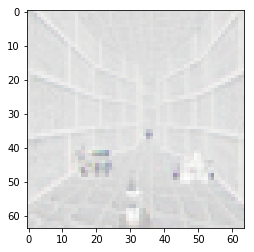

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.14901961 0.15294118 0.09019608 0.16470589]
  [0.13725491 0.14901961 0.1254902  0.08627451]
  [0.14509805 0.13333334 0.14117648 0.09019608]
  ...
  [0.16862746 0.1254902  0.15294118 0.2       ]
  [0.13333334 0.16078432 0.2        0.1882353 ]
  [0.09411765 0.14901961 0.2        0.17254902]]

 [[0.15686275 0.15686275 0.07843138 0.21568628]
  [0.15294118 0.15686275 0.08235294 0.19215687]
  [0.13333334 0.14509805 0.12941177 0.07843138]
  ...
  [0.17254902 0.14509805 0.16078432 0.16862746]
  [0.10588235 0.16078432 0.18431373 0.16862746]
  [0.11764706 0.14901961 0.1882353  0.16470589]]

 [[0.15686275 0.09019608 0.19607843 0.19607843]
  [0.14509805 0.13725491 0.09019608 0.22352941]
  [0.12156863 0.15294118 0.08627451 0.16862746]
  ...
  [0.14901961 0.14117648 0.18431373 0.14901961]
  [0.10196079 0.15294118 0.18431373 0.17254902]
  [0.19607843 0.14901961 0.18039216 0.16862746]]

 ...

 [[0.19215687 0

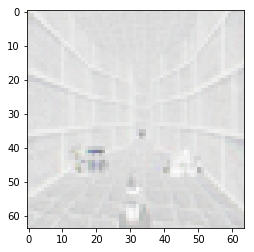

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 1 0]
(412, 64, 64, 4)
[[[0.16470589 0.13333334 0.09019608 0.15294118]
  [0.18431373 0.16862746 0.12156863 0.07843138]
  [0.16862746 0.18039216 0.16078432 0.0627451 ]
  ...
  [0.1764706  0.16078432 0.13333334 0.14117648]
  [0.17254902 0.16862746 0.14509805 0.16078432]
  [0.18431373 0.2        0.15686275 0.18039216]]

 [[0.15294118 0.08627451 0.1764706  0.24313726]
  [0.1764706  0.1254902  0.09019608 0.2       ]
  [0.17254902 0.17254902 0.11764706 0.09019608]
  ...
  [0.16862746 0.16862746 0.15294118 0.14117648]
  [0.2        0.15686275 0.14901961 0.13725491]
  [0.20392157 0.18431373 0.15294118 0.15686275]]

 [[0.10980392 0.1254902  0.2627451  0.20392157]
  [0.13333334 0.09803922 0.21176471 0.23529412]
  [0.16862746 0.10980392 0.11372549 0.23921569]
  ...
  [0.18431373 0.1882353  0.13725491 0.15686275]
  [0.19607843 0.15294118 0.14509805 0.16862746]
  [0.20392157 0.18039216 0.15294118 0.15686275]]

 ...

 [[0.19607843 0

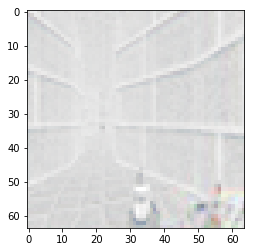

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)
[[[0.19215687 0.16078432 0.17254902 0.17254902]
  [0.12941177 0.18039216 0.16862746 0.16862746]
  [0.15294118 0.1882353  0.1764706  0.1764706 ]
  ...
  [0.15294118 0.14509805 0.13725491 0.13725491]
  [0.08235294 0.1254902  0.13725491 0.13725491]
  [0.06666667 0.14117648 0.1254902  0.1254902 ]]

 [[0.17254902 0.18431373 0.18431373 0.18431373]
  [0.1254902  0.1764706  0.18431373 0.18431373]
  [0.14901961 0.18431373 0.1764706  0.1764706 ]
  ...
  [0.14901961 0.14901961 0.13333334 0.13333334]
  [0.07843138 0.13333334 0.13333334 0.13333334]
  [0.07450981 0.09803922 0.1254902  0.1254902 ]]

 [[0.14901961 0.1882353  0.18431373 0.18431373]
  [0.11372549 0.18039216 0.17254902 0.17254902]
  [0.16862746 0.16470589 0.16470589 0.16470589]
  ...
  [0.09803922 0.13725491 0.13725491 0.13725491]
  [0.08627451 0.10588235 0.14117648 0.14117648]
  [0.18039216 0.07450981 0.13725491 0.13725491]]

 ...

 [[0.15294118 0

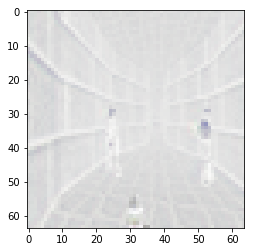

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]


In [196]:
for i in tf.range(10):
    states, actions, rewards, n_states, dones, rand_idx = load_random_data()
    print(states[rand_idx[0]])
    test_img = states[rand_idx[0]]
    plt.imshow(test_img)
    plt.show()
    
    action = model(test_img[np.newaxis])
    acc_action = actions[rand_idx[0]]
    
    print("Guessed action: ", np.round(action))
    print("Actual action: ", acc_action)

In [190]:
model.save("MIMICKING_SHOOTER.h5")